##Purpose:

This brings in .CSV files of user ITEM, Review Scores and uses keras to generate weights (dot product factorization machine). Then we re-use those weights to find Anime which are similar to each other.  
We do this in Keras primarily for performance; by using keras we can have this computation done in GPU. 

## This has not been refactored:
This is basically an 'experiment book' to find a set of recommendations weird enough that they don't overlap with other methods, but still logical enough to provide value. 

In [1]:
import numpy as np
from keras import backend as K
from keras.layers import Input, Embedding, merge
import keras.layers
from keras.regularizers import l2, l1
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import plot_model
from IPython.display import SVG
from sklearn.metrics import pairwise_distances
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
csvtoload = 'mal_scores_train_nonzero_v2.csv'# This is a subset of reviews 0's included. 

In [4]:
ratings = pd.read_csv(csvtoload) # This is a subset of reviews with all 0's dropped. 
ratings['userid']=ratings['index']
ratings['score']=ratings['animescore']
ratings_test = pd.read_csv('mal_scores_test_nonzero_v2.csv')

In [5]:
ratings.tail()

,Unnamed: 0,Unnamed: 0.1,animeid,animescore,index,name,status,unkey,userid,score,useravg,animeavg,score_anime_scaled,score_usr_scaled
10914893,10914893,41709544,2001,10,Verdex9,Verdex9,COMPLETED,2001Verdex9,Verdex9,10,9.5,8.681996,1.318004,0.5
10914894,10914894,41709545,523,10,Verdex9,Verdex9,COMPLETED,523Verdex9,Verdex9,10,9.5,8.496606,1.503394,0.5
10914895,10914895,41709546,4224,10,Verdex9,Verdex9,COMPLETED,4224Verdex9,Verdex9,10,9.5,8.397036,1.602964,0.5
10914896,10914896,41709547,27,9,Verdex9,Verdex9,COMPLETED,27Verdex9,Verdex9,9,9.5,7.439252,1.560748,-0.5
10914897,10914897,41709548,935,10,Verdex9,Verdex9,COMPLETED,935Verdex9,Verdex9,10,9.5,7.367396,2.632604,0.5


We have several choices here: Let's start by testing only 'complete' shows. 

In [6]:

ratings = ratings[ratings['status']=='COMPLETED']

In [7]:
ratings.head()

,Unnamed: 0,Unnamed: 0.1,animeid,animescore,index,name,status,unkey,userid,score,useravg,animeavg,score_anime_scaled,score_usr_scaled
0,0,13202,2001,10,Lancerevomr,Lancerevomr,COMPLETED,2001Lancerevomr,Lancerevomr,10,10.0,8.681996,1.318004,0.0
1,1,21990,10719,10,kuelpanda,kuelpanda,COMPLETED,10719kuelpanda,kuelpanda,10,9.5,7.535472,2.464528,0.5
2,2,21991,10155,9,kuelpanda,kuelpanda,COMPLETED,10155kuelpanda,kuelpanda,9,9.5,7.105895,1.894105,-0.5
3,3,22409,15051,10,vxxyman,vxxyman,COMPLETED,15051vxxyman,vxxyman,10,10.0,7.654129,2.345871,0.0
4,4,23792,1,10,pinheiro,pinheiro,COMPLETED,1pinheiro,pinheiro,10,10.0,8.804023,1.195977,0.0


I am assuming my data has alread been sanitized here.  0's have been removed, and we have scores that are scaled to usr (more or less than the user's avg)  and to anime (more or less than the anime's average score)

In [8]:
#users = ratings.userid.unique()
#animes = ratings.animeid.unique()
#userid mapping
users1 = ratings.userid.unique()
users2 = ratings_test.userid.unique()

#animeid mapping
anime1= ratings.animeid.unique()
anime2=ratings_test.animeid.unique()
users = set(users1).union(set(users2))
animes = set(anime1).union(set(anime2))

We need a unique list of users and of animes. 

In [9]:
userid2idx = {o:i for i,o in enumerate(users)} # turn the user strings into a numerical value. 
animeid2idx = {o:i for i,o in enumerate(animes)} # remove missing anime numbers and re-order

In [10]:
ratings['anime_id_embed'] = ratings.animeid.apply(lambda x: animeid2idx[x]) #the above code set up mapping, this applies it. 
ratings['user_id_embed'] = ratings.userid.apply(lambda x: userid2idx[x])# the above code set up mapping, this applies it. 
ratings_test['anime_id_embed'] = ratings_test.animeid.apply(lambda x: animeid2idx[x]) #the above code set up mapping, this applies it. 
ratings_test['user_id_embed'] = ratings_test.userid.apply(lambda x: userid2idx[x])# the above code set up mapping, this applies it. 


In [11]:
ratings.head()

,Unnamed: 0,Unnamed: 0.1,animeid,animescore,index,name,status,unkey,userid,score,useravg,animeavg,score_anime_scaled,score_usr_scaled,anime_id_embed,user_id_embed
0,0,13202,2001,10,Lancerevomr,Lancerevomr,COMPLETED,2001Lancerevomr,Lancerevomr,10,10.0,8.681996,1.318004,0.0,1984,65672
1,1,21990,10719,10,kuelpanda,kuelpanda,COMPLETED,10719kuelpanda,kuelpanda,10,9.5,7.535472,2.464528,0.5,6984,75288
2,2,21991,10155,9,kuelpanda,kuelpanda,COMPLETED,10155kuelpanda,kuelpanda,9,9.5,7.105895,1.894105,-0.5,6709,75288
3,3,22409,15051,10,vxxyman,vxxyman,COMPLETED,15051vxxyman,vxxyman,10,10.0,7.654129,2.345871,0.0,8000,13707
4,4,23792,1,10,pinheiro,pinheiro,COMPLETED,1pinheiro,pinheiro,10,10.0,8.804023,1.195977,0.0,1,47718


It's important to note that anime_id and userid count up from 0.  If we use animeid rather than anime_id in any of the following code things will break (exploding gradients) 

In [12]:
user_min, user_max, anime_min, anime_max = (ratings.userid.min(), 
    ratings.userid.max(), ratings.animeid.min(), ratings.animeid.max())
user_min, user_max, anime_min, anime_max

('---L-AND-AME-4EV', 'zzzxxx123', 1, 36145)

In [13]:
n_users = ratings.user_id_embed.nunique()
n_animes = ratings.anime_id_embed.nunique()
n_users, n_animes

(177818, 11057)

Next we decide how many latent factors to use. We'll only know if we have too few or too many once we start looking at the weights later. If the factors are interpretable (with or without pca) we'll know we have a good number. 

In [14]:
n_factors = 20

In [15]:
user_in = Input(shape=(1,), dtype='int64', name='user_id_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(.05),name='Embed_User_Hidden_Factors')(user_in)
anime_in = Input(shape=(1,), dtype='int64', name='anime_id_in')
m = Embedding(n_animes, n_factors, input_length=1, embeddings_regularizer=l2(0),name='Embed_Anime_Hidden_Factors')(anime_in)

In [16]:
x = keras.layers.dot([u, m], axes=2,name='DotProduct')
#x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, anime_in], x)
model.compile(Adam(0.001), loss='mae')

In [17]:
model.lr=.5

In [18]:
model.fit([ratings.user_id_embed, ratings.anime_id_embed], ratings.score_usr_scaled, batch_size=5120, epochs=8, 
          validation_data=([ratings_test.user_id_embed, ratings_test.anime_id_embed], ratings_test.score_usr_scaled)) # we want to set the batch size to the max the gpu can handle. This is a gtx 1060 6b

Train on 9935029 samples, validate on 1210873 samples
Epoch 1/8
9935029/9935029 [==============================] - 19s - loss: 2.1521 - val_loss: 1.0786
Epoch 2/8
9935029/9935029 [==============================] - 18s - loss: 1.0437 - val_loss: 1.0787
Epoch 3/8
9935029/9935029 [==============================] - 18s - loss: 1.0437 - val_loss: 1.0787
Epoch 4/8
9935029/9935029 [==============================] - 19s - loss: 1.0438 - val_loss: 1.0789
Epoch 5/8
9935029/9935029 [==============================] - 18s - loss: 1.0440 - val_loss: 1.0792
Epoch 6/8
9935029/9935029 [==============================] - 19s - loss: 1.0443 - val_loss: 1.0796
Epoch 7/8
9935029/9935029 [==============================] - 18s - loss: 1.0448 - val_loss: 1.0804
Epoch 8/8
9935029/9935029 [==============================] - 18s - loss: 1.0458 - val_loss: 1.0819


In [19]:
#model.lr=.1

In [20]:
#model.fit([trn.userid, trn.anime_id], trn.score, batch_size=5120, epochs=18, 
#          validation_data=([val.userid, val.anime_id], val.score))

In [21]:
#plot_model(model, to_file='dot22.png')

In [22]:
#model.save_weights('latentfactorslogical.h2a')

We can see that we have begun to overfit. 
However, the point of these latent factors is not (yet) to make predictions, but to check the latent factors to see what that tells us about anime. 
It's important to note several things at this point. 
The first is that if we wanted to improve our MAE/MSE we would add bias terms (which we will later). We are intentionally leaving out bias terms because that forces every anime's user score to be be based entirely on it's latent factors.
The second is that this is an unusual data set to feed into this: The merging of uncompleted / will be watched in the future shows is unusual. 


Anime analysis:
Let's look at some anime and break them into their factors.

In [23]:
g=ratings.groupby('animeid')['score'].count()
topAnime=g.sort_values(ascending=False)[:2500]
topAnime = np.array(topAnime.index) # we're only going to worry about the top 2500 best reviewed anime for now. 


In [24]:
topAnime2 = []

In [25]:
for num in range(len(topAnime)):
    topAnime2.append(animeid2idx[topAnime[num]])

In [26]:
topAnime2 = np.array(topAnime2)

In [29]:
anime_names = pd.read_csv('Data/animeinfo3.csv').set_index('animeid')['name'].to_dict()

In [30]:
get_anime_emb = Model(anime_in, m)
anime_emb = np.squeeze(get_anime_emb.predict([topAnime2]))
anime_emb.shape


(2500, 20)

So now we have N hidden factors for the top 1750 rated anime. 
Let's turn that into a sparse matrix, and do some pairwise distance. 

In [31]:
anime_latentfactors= sparse.csc_matrix(anime_emb)

In [32]:
anime_similaritycos = cosine_similarity(anime_latentfactors)
latentfactor_similaritycos = cosine_similarity(anime_latentfactors.T)

In [33]:
anime_similaritypair=pairwise_distances(anime_latentfactors.T, metric='cosine')
latentfactor_similaritypair=pairwise_distances(anime_latentfactors, metric='cosine')

In [34]:
anime_similaritycos.shape

(2500, 2500)

In [35]:
orderednames= pd.DataFrame(topAnime.T)

In [36]:
orderednames['anime'] =orderednames[0].map(anime_names)

In [37]:
anime_sim_cos_df = pd.DataFrame(anime_similaritycos, index =orderednames.anime.values , columns=orderednames.anime.values)
anime_sim_cos_num_df = pd.DataFrame(anime_similaritycos, index =topAnime , columns=topAnime)


In [38]:
#animeinfo3 = pd.read_csv('animeinfo3.csv')

In [39]:
anime_sim_cos_df.head()

,Death Note,Shingeki no Kyojin,Sword Art Online,Fullmetal Alchemist: Brotherhood,Angel Beats!,Code Geass: Hangyaku no Lelouch,Tokyo Ghoul,Naruto,One Punch Man,No Game No Life,...,Youjuu Toshi,Galaxy Angel,Video Girl Ai,Oneechan ga Kita Special,Kyuuketsuhime Miyu (TV),Zegapain,Brave Witches,Hanaukyou Maid-tai: La Verite,Ghost in the Shell: Stand Alone Complex 2nd GIG - Individual Eleven,Ichigo 100%: Koi ga Hajimaru?! Satsuei Gasshuku - Yureru Kokoro ga Higashi e Nishi e
Death Note,1.000000,0.964773,0.524267,0.978242,0.971031,0.986122,0.863061,-0.784907,0.977961,0.964581,...,-0.841243,0.136756,0.351270,-0.213778,0.595347,0.531555,-0.853848,-0.542550,0.752498,-0.788911
Shingeki no Kyojin,0.964773,1.000000,0.619166,0.984202,0.971059,0.981284,0.911651,-0.665092,0.978622,0.978041,...,-0.823402,0.187328,0.355519,-0.339763,0.570752,0.584278,-0.803676,-0.507205,0.760897,-0.766701
Sword Art Online,0.524267,0.619166,1.000000,0.593460,0.612037,0.550079,0.580390,-0.193422,0.584177,0.569397,...,-0.499470,0.188639,0.393175,-0.524951,0.404999,0.423741,-0.401243,-0.153556,0.333672,-0.462922
Fullmetal Alchemist: Brotherhood,0.978242,0.984202,0.593460,1.000000,0.979692,0.985408,0.880427,-0.708491,0.980735,0.975217,...,-0.841588,0.132992,0.355325,-0.320761,0.585785,0.570404,-0.804463,-0.507799,0.776966,-0.801923
Angel Beats!,0.971031,0.971059,0.612037,0.979692,1.000000,0.971394,0.878111,-0.680088,0.979214,0.981719,...,-0.813864,0.155934,0.372613,-0.265491,0.596542,0.609820,-0.844082,-0.504368,0.746932,-0.784742


In [40]:
anime_sim_cos_df.loc[:,'Death Note'].sort_values()[-20:]

Noragami                                 0.978447
Shigatsu wa Kimi no Uso                  0.978928
JoJo no Kimyou na Bouken (TV)            0.979720
NHK ni Youkoso!                          0.980335
Shokugeki no Souma                       0.980527
Mushishi Zoku Shou                       0.981172
Hellsing Ultimate                        0.981566
Fate/Zero                                0.981641
Toradora!                                0.982278
Kara no Kyoukai 5: Mujun Rasen           0.982921
Gintama'                                 0.983252
Steins;Gate                              0.984763
Toki wo Kakeru Shoujo                    0.984773
Kiseijuu: Sei no Kakuritsu               0.985367
Durarara!!                               0.985903
Re:Zero kara Hajimeru Isekai Seikatsu    0.986073
Code Geass: Hangyaku no Lelouch          0.986122
Code Geass: Hangyaku no Lelouch R2       0.987876
Mononoke Hime                            0.988641
Death Note                               1.000000


In [41]:
anime_sim_cos_df.loc[:,'Shingeki no Kyojin'].sort_values()[-20:]

Toki wo Kakeru Shoujo                     0.979113
Shingeki no Kyojin Season 2               0.979237
Haikyuu!!                                 0.979295
Clannad                                   0.979644
Kuroko no Basket                          0.979720
Kiseijuu: Sei no Kakuritsu                0.980245
Code Geass: Hangyaku no Lelouch           0.981284
Re:Zero kara Hajimeru Isekai Seikatsu     0.982140
Clannad: After Story                      0.982229
Steins;Gate                               0.982398
Bakuman. 3rd Season                       0.982662
Haikyuu!! Second Season                   0.982790
Shigatsu wa Kimi no Uso                   0.983369
Shokugeki no Souma                        0.983714
Usagi Drop                                0.983726
Fullmetal Alchemist: Brotherhood          0.984202
Mushishi                                  0.984331
Gyakkyou Burai Kaiji: Hakairoku-hen       0.985368
Fate/stay night: Unlimited Blade Works    0.988463
Shingeki no Kyojin             

In [42]:
anime_sim_cos_df.loc[:,'Naruto'].sort_values()[-20:]

Yozakura Quartet                                                                   0.781834
Senran Kagura                                                                      0.781943
Karneval (TV)                                                                      0.782012
Natsu-iro Kiseki                                                                   0.784384
World Destruction: Sekai Bokumetsu no Rokunin                                      0.784666
Medaka Box                                                                         0.785365
Highschool of the Dead: Drifters of the Dead                                       0.786310
Blood Lad: Wagahai wa Neko de wa Nai                                               0.786447
Yu☆Gi☆Oh!: Duel Monsters GX                                                        0.795877
Kanokon                                                                            0.796143
Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka Gaiden: Sword Oratoria 

In [43]:
anime_sim_cos_df.loc[:,'Fullmetal Alchemist: Brotherhood'].sort_values()[-20:]

Fate/Zero 2nd Season                                     0.983477
Toradora!                                                0.983824
Shingeki no Kyojin                                       0.984202
Barakamon                                                0.984475
Code Geass: Hangyaku no Lelouch                          0.985408
Gintama'                                                 0.985958
Suzumiya Haruhi no Shoushitsu                            0.986416
Hotarubi no Mori e                                       0.986516
Code Geass: Hangyaku no Lelouch R2                       0.987248
Fate/Zero                                                0.987466
Monogatari Series: Second Season                         0.988769
Shokugeki no Souma                                       0.988991
Kiseijuu: Sei no Kakuritsu                               0.989029
Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare    0.989076
Shigatsu wa Kimi no Uso                                  0.989130
Psycho-Pas

In [44]:
anime_sim_cos_df.loc[:,'Bakemonogatari'].sort_values()[-20:]

Shingeki no Kyojin                                           0.974364
ef: A Tale of Melodies.                                      0.974578
Baccano!                                                     0.974809
Haikyuu!! Second Season                                      0.975146
Re:Zero kara Hajimeru Isekai Seikatsu                        0.975755
Mushishi Special: Hihamukage                                 0.975885
Clannad: After Story                                         0.975969
Hotarubi no Mori e                                           0.977020
Death Note                                                   0.977526
No Game No Life                                              0.978153
Fate/Zero                                                    0.979002
Fullmetal Alchemist: Brotherhood                             0.979345
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou    0.979369
Suzumiya Haruhi no Shoushitsu                                0.980295
Fate/stay night: Unl

In [45]:
anime_sim_cos_df.loc[:,'Girls und Panzer'].sort_values()[-20:]

Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa        0.545845
Tegamibachi Reverse                                 0.546465
Kamisama no Memochou                                0.549703
Lupin III vs. Detective Conan                       0.549833
Detective Conan Movie 13: The Raven Chaser          0.554212
K                                                   0.554276
Yuu☆Yuu☆Hakusho                                     0.555091
Flip Flappers                                       0.561028
Kuzu no Honkai                                      0.563748
Keroro Gunsou                                       0.575781
Saki                                                0.591677
Kemono Friends                                      0.608747
Ghost in the Shell: Arise - Border:3 Ghost Tears    0.621117
Gunslinger Girl                                     0.629962
Mousou Dairinin                                     0.635003
Naruto: Shippuuden                                  0.654719
C: The Money of Soul and

In [46]:
n_factors = 28

In [47]:
msk = np.random.rand(len(ratings)) < 0.8 #training vs test set ratio
trn = ratings[msk]
val = ratings[~msk]

In [48]:
user_in = Input(shape=(1,), dtype='int64', name='user_id_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(.00005),name='Embed_User_Hidden_Factors')(user_in)
anime_in = Input(shape=(1,), dtype='int64', name='anime_id_in')
m = Embedding(n_animes, n_factors, input_length=1, embeddings_regularizer=l2(0),name='Embed_Anime_Hidden_Factors')(anime_in)

In [49]:
x = keras.layers.dot([u, m], axes=2,name='DotProduct')
#x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, anime_in], x)
model.compile(Adam(0.001), loss='mae')

In [50]:
model.lr=.5

In [51]:
model.fit([trn.user_id_embed, trn.anime_id_embed], trn.score_usr_scaled, batch_size=5120, epochs=8, 
          validation_data=([val.user_id_embed, val.anime_id_embed], val.score_usr_scaled)) # we want to set the batch size to the max the gpu can handle. This is a gtx 1060 6b

Train on 7947951 samples, validate on 1987078 samples
Epoch 1/8
7947951/7947951 [==============================] - 17s - loss: 1.0376 - val_loss: 1.0138
Epoch 2/8
7947951/7947951 [==============================] - 17s - loss: 0.9991 - val_loss: 0.9912
Epoch 3/8
7947951/7947951 [==============================] - 16s - loss: 0.9836 - val_loss: 0.9810
Epoch 4/8
7947951/7947951 [==============================] - 16s - loss: 0.9754 - val_loss: 0.9753
Epoch 5/8
7947951/7947951 [==============================] - 17s - loss: 0.9703 - val_loss: 0.9714
Epoch 6/8
7947951/7947951 [==============================] - 16s - loss: 0.9666 - val_loss: 0.9690
Epoch 7/8
7947951/7947951 [==============================] - 16s - loss: 0.9640 - val_loss: 0.9668
Epoch 8/8
7947951/7947951 [==============================] - 17s - loss: 0.9617 - val_loss: 0.9650


In [52]:
#model.lr=.1

In [53]:
#model.fit([trn.userid, trn.anime_id], trn.score, batch_size=5120, epochs=18, 
#          validation_data=([val.userid, val.anime_id], val.score))

In [54]:
#plot_model(model, to_file='dot22.png')

In [55]:
#model.save_weights('latentfactorslogical.h2a')

We can see that we have begun to overfit. 
However, the point of these latent factors is not (yet) to make predictions, but to check the latent factors to see what that tells us about anime. 
It's important to note several things at this point. 
The first is that if we wanted to improve our MAE/MSE we would add bias terms (which we will later). We are intentionally leaving out bias terms because that forces every anime's user score to be be based entirely on it's latent factors.
The second is that this is an unusual data set to feed into this: The merging of uncompleted / will be watched in the future shows is unusual. 


Anime analysis:
Let's look at some anime and break them into their factors.

In [56]:
g=ratings.groupby('animeid')['score'].count()
topAnime=g.sort_values(ascending=False)[:2500]
topAnime = np.array(topAnime.index) # we're only going to worry about the top 2500 best reviewed anime for now. 


In [57]:
topAnime2 = []

In [58]:
for num in range(len(topAnime)):
    topAnime2.append(animeid2idx[topAnime[num]])

In [59]:
topAnime2 = np.array(topAnime2)

In [61]:
anime_names = pd.read_csv('Data/animeinfo3.csv').set_index('animeid')['name'].to_dict()

In [62]:
get_anime_emb = Model(anime_in, m)
anime_emb = np.squeeze(get_anime_emb.predict([topAnime2]))
anime_emb.shape


(2500, 28)

So now we have N hidden factors for the top 1750 rated anime. 
Let's turn that into a sparse matrix, and do some pairwise distance. 

In [63]:
anime_latentfactors= sparse.csc_matrix(anime_emb)

In [64]:
anime_similaritycos = cosine_similarity(anime_latentfactors)
latentfactor_similaritycos = cosine_similarity(anime_latentfactors.T)

In [65]:
anime_similaritypair=pairwise_distances(anime_latentfactors.T, metric='cosine')
latentfactor_similaritypair=pairwise_distances(anime_latentfactors, metric='cosine')

In [343]:
anime_similaritycos.shape

(6000, 6000)

In [67]:
orderednames= pd.DataFrame(topAnime.T)

In [68]:
orderednames['anime'] =orderednames[0].map(anime_names)

In [69]:
anime_sim_cos_df = pd.DataFrame(anime_similaritycos, index =orderednames.anime.values , columns=orderednames.anime.values)
anime_sim_cos_num_df = pd.DataFrame(anime_similaritycos, index =topAnime , columns=topAnime)


In [350]:
anime_sim_cos_num_df.to_csv('lf_sim_animeid.csv')

In [349]:
anime_sim_cos_df.head()

,Death Note,Shingeki no Kyojin,Sword Art Online,Fullmetal Alchemist: Brotherhood,Angel Beats!,Code Geass: Hangyaku no Lelouch,Tokyo Ghoul,Naruto,One Punch Man,No Game No Life,...,Ai Monogatari: 9 Love Stories,Hanamaru Youchien: Panda Neko Taisou,Dragon Knight 4,Lupin the Third,Oppai Infinity∞! The Animation,6 Angels,Shinshou Genmukan,Hitotsubu ni Kawaranu Ai wo Komete,Samurai Hormone The Animation,Detective Conan: Conan vs. Kid - Jet Black Sniper
Death Note,1.000000,0.987974,0.104711,0.978548,0.963560,0.996231,0.633430,0.129867,0.997987,0.962880,...,0.763513,-0.877030,-0.892379,-0.856378,-0.913904,-0.897274,-0.143542,-0.912462,-0.928695,-0.620878
Shingeki no Kyojin,0.987974,1.000000,0.245330,0.938857,0.990947,0.976082,0.740279,0.272049,0.979983,0.990765,...,0.729258,-0.816072,-0.845514,-0.793535,-0.868048,-0.839325,-0.078559,-0.876994,-0.886708,-0.642232
Sword Art Online,0.104711,0.245330,1.000000,-0.056296,0.362359,0.060051,0.829074,0.993761,0.068080,0.366231,...,0.008823,0.140022,0.032921,0.137599,0.038357,0.117260,0.414334,-0.045818,0.013532,-0.368409
Fullmetal Alchemist: Brotherhood,0.978548,0.938857,-0.056296,1.000000,0.899848,0.990701,0.486833,-0.037838,0.987969,0.898203,...,0.805253,-0.947722,-0.947820,-0.930889,-0.962102,-0.960859,-0.239119,-0.951391,-0.970621,-0.606344
Angel Beats!,0.963560,0.990947,0.362359,0.899848,1.000000,0.948418,0.814399,0.384882,0.952383,0.999248,...,0.713058,-0.778381,-0.820916,-0.757931,-0.839949,-0.803517,-0.021676,-0.860377,-0.861187,-0.679301


In [72]:
anime_sim_cos_df.loc[:,'Death Note'].sort_values()[-20:]

Shingeki no Kyojin: Kuinaki Sentaku                         0.954226
Howl no Ugoku Shiro                                         0.955370
Kuroko no Basket 3rd Season                                 0.959050
Steins;Gate Movie: Fuka Ryouiki no Déjà vu                  0.961517
Psycho-Pass                                                 0.962276
Haikyuu!!                                                   0.963055
Death Parade                                                0.963656
Fate/stay night: Unlimited Blade Works                      0.964012
Fate/stay night: Unlimited Blade Works 2nd Season           0.965966
Ansatsu Kyoushitsu (TV) 2nd Season                          0.966063
Boku dake ga Inai Machi                                     0.968173
Shokugeki no Souma                                          0.968393
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.    0.973907
Shigatsu wa Kimi no Uso                                     0.977410
Kiseijuu: Sei no Kakuritsu        

In [73]:
anime_sim_cos_df.loc[:,'Shingeki no Kyojin'].sort_values()[-20:]

Shingeki no Kyojin Season 2                          0.939505
Nanatsu no Taizai                                    0.940853
Ansatsu Kyoushitsu (TV)                              0.941280
No Game No Life                                      0.943199
Kiseijuu: Sei no Kakuritsu                           0.944904
Magi: The Kingdom of Magic                           0.946861
Kuroko no Basket 3rd Season                          0.947288
Shokugeki no Souma                                   0.951952
Fate/stay night: Unlimited Blade Works 2nd Season    0.952907
Death Note                                           0.953036
Magi: The Labyrinth of Magic                         0.953197
Fate/stay night: Unlimited Blade Works               0.959035
Kuroko no Basket                                     0.959603
Re:Zero kara Hajimeru Isekai Seikatsu                0.963029
Zankyou no Terror                                    0.964012
Kuroko no Basket 2nd Season                          0.964898
Noragami

In [74]:
anime_sim_cos_df.loc[:,'Naruto'].sort_values()[-20:]

Naruto: Shippuuden Movie 6 - Road to Ninja                      0.902062
No.6                                                            0.902704
Ao no Exorcist Movie                                            0.905063
Fairy Tail                                                      0.905929
Psycho-Pass 2                                                   0.906003
Shaman King                                                     0.909865
Charlotte                                                       0.917937
Btooom!                                                         0.918124
Aldnoah.Zero                                                    0.919312
K                                                               0.922586
Owari no Seraph                                                 0.929289
Dragon Ball Z Movie 12: Fukkatsu no Fusion!! Gokuu to Vegeta    0.939519
Owari no Seraph: Nagoya Kessen-hen                              0.942178
Dungeon ni Deai wo Motomeru no wa Machigatteiru Dar

In [75]:
anime_sim_cos_df.loc[:,'Fullmetal Alchemist: Brotherhood'].sort_values()[-20:]

Great Teacher Onizuka                                        0.968842
Berserk: Ougon Jidai-hen III - Kourin                        0.969098
Samurai Champloo                                             0.970249
Hajime no Ippo                                               0.970344
Shigatsu wa Kimi no Uso                                      0.971691
Shinsekai yori                                               0.971908
Mononoke Hime                                                0.973110
Koe no Katachi                                               0.975488
Fate/Zero                                                    0.975794
JoJo no Kimyou na Bouken: Stardust Crusaders 2nd Season      0.978651
Howl no Ugoku Shiro                                          0.979398
Ookami Kodomo no Ame to Yuki                                 0.980900
Haikyuu!! Second Season                                      0.982867
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou    0.985655
Tengen Toppa Gurren 

In [76]:
anime_sim_cos_df.loc[:,'Bakemonogatari'].sort_values()[-20:]

Kara no Kyoukai 5: Mujun Rasen                  0.980429
Ookami to Koushinryou II                        0.980867
Little Witch Academia: Mahoujikake no Parade    0.981000
Monogatari Series: Second Season                0.981016
Flip Flappers                                   0.981339
Katanagatari                                    0.981664
Evangelion: 2.0 You Can (Not) Advance           0.981731
Byousoku 5 Centimeter                           0.982214
Toki wo Kakeru Shoujo                           0.982560
Nichijou                                        0.982653
Evangelion: 1.0 You Are (Not) Alone             0.983260
Azumanga Daioh                                  0.983573
Little Witch Academia                           0.983619
Owarimonogatari                                 0.983669
Suzumiya Haruhi no Shoushitsu                   0.986435
Hanamonogatari                                  0.986650
Hibike! Euphonium                               0.987817
Ookami to Koushinryou          

In [77]:
anime_sim_cos_df.loc[:,'Girls und Panzer'].sort_values()[-20:]

Garo: Honoo no Kokuin          0.946765
D-Frag!                        0.946904
Rec                            0.947767
Moyashimon Returns             0.949728
Gochuumon wa Usagi desu ka?    0.950381
"Bungaku Shoujo" Movie         0.953484
Yuru Yuri                      0.954350
Yuyushiki                      0.954467
Love Lab                       0.957084
Saki                           0.957334
Saishuu Heiki Kanojo           0.958811
Saki Zenkoku-hen               0.963471
Hayate no Gotoku!              0.966318
Seitokai Yakuindomo            0.967193
Scrapped Princess              0.968373
Shinryaku!? Ika Musume         0.974963
Kyoukaisenjou no Horizon II    0.976347
Mahou Shoujo Lyrical Nanoha    0.982177
Shinryaku! Ika Musume          0.991658
Girls und Panzer               1.000000
Name: Girls und Panzer, dtype: float32

In [278]:
n_factors = 52

In [279]:
msk = np.random.rand(len(ratings)) < 0.8 #training vs test set ratio
trn = ratings[msk]
val = ratings[~msk]

In [351]:
user_in = Input(shape=(1,), dtype='int64', name='user_id_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(.065),name='Embed_User_Hidden_Factors')(user_in)
anime_in = Input(shape=(1,), dtype='int64', name='anime_id_in')
m = Embedding(n_animes, n_factors, input_length=1, embeddings_regularizer=l2(0),name='Embed_Anime_Hidden_Factors')(anime_in)

In [352]:
x = keras.layers.dot([u, m], axes=2,name='DotProduct')
#x = merge([u, m], mode='dot')
x = Flatten()(x)
model2 = Model([user_in, anime_in], x)
model2.compile(Adam(0.001), loss='mae')

In [353]:
model.lr=.5

In [354]:
model2.fit([trn.user_id_embed, trn.anime_id_embed], trn.score_anime_scaled, batch_size=5120, epochs=8, 
          validation_data=([val.user_id_embed, val.anime_id_embed], val.score_anime_scaled)) # we want to set the batch size to the max the gpu can handle. This is a gtx 1060 6b

Train on 7946019 samples, validate on 1989010 samples
Epoch 1/8
7946019/7946019 [==============================] - 21s - loss: 5.8221 - val_loss: 1.1350
Epoch 2/8
7946019/7946019 [==============================] - 20s - loss: 1.1350 - val_loss: 1.1351
Epoch 3/8
7946019/7946019 [==============================] - 20s - loss: 1.1350 - val_loss: 1.1352
Epoch 4/8
7946019/7946019 [==============================] - 20s - loss: 1.1352 - val_loss: 1.1353
Epoch 5/8
7946019/7946019 [==============================] - 20s - loss: 1.1353 - val_loss: 1.1356
Epoch 6/8
7946019/7946019 [==============================] - 20s - loss: 1.1357 - val_loss: 1.1361
Epoch 7/8
7946019/7946019 [==============================] - 20s - loss: 1.1363 - val_loss: 1.1368
Epoch 8/8
7946019/7946019 [==============================] - 20s - loss: 1.1371 - val_loss: 1.1378


In [355]:
#model.lr=.1

In [356]:
#model.fit([trn.userid, trn.anime_id], trn.score, batch_size=5120, epochs=18, 
#          validation_data=([val.userid, val.anime_id], val.score))

In [357]:
#plot_model(model, to_file='dot22.png')

In [358]:
#model.save_weights('latentfactorslogical.h2a')

We can see that we have begun to overfit. 
However, the point of these latent factors is not (yet) to make predictions, but to check the latent factors to see what that tells us about anime. 
It's important to note several things at this point. 
The first is that if we wanted to improve our MAE/MSE we would add bias terms (which we will later). We are intentionally leaving out bias terms because that forces every anime's user score to be be based entirely on it's latent factors.
The second is that this is an unusual data set to feed into this: The merging of uncompleted / will be watched in the future shows is unusual. 


Anime analysis:
Let's look at some anime and break them into their factors.

In [379]:
g=ratings.groupby('animeid')['score'].count()
topAnime=g.sort_values(ascending=False)[:9000]
topAnime = np.array(topAnime.index) # we're only going to worry about the top 2500 best reviewed anime for now. 


In [380]:
topAnime2 = []

In [381]:
for num in range(len(topAnime)):
    topAnime2.append(animeid2idx[topAnime[num]])

In [382]:
topAnime2 = np.array(topAnime2)

In [383]:
anime_names = pd.read_csv('Data/animeinfo3.csv').set_index('animeid')['name'].to_dict()

In [384]:
get_anime_emb = Model(anime_in, m)
anime_emb = np.squeeze(get_anime_emb.predict([topAnime2]))
anime_emb.shape


(9000, 52)

So now we have N hidden factors for the top 2500 rated anime based on scaled_anime_score.

Let's turn that into a sparse matrix, and do some pairwise distance. 

In [385]:
anime_latentfactors= sparse.csc_matrix(anime_emb)

In [386]:
anime_similaritycos = cosine_similarity(anime_latentfactors)
latentfactor_similaritycos = cosine_similarity(anime_latentfactors.T)

In [387]:
anime_similaritypair=pairwise_distances(anime_latentfactors.T, metric='cosine')
latentfactor_similaritypair=pairwise_distances(anime_latentfactors, metric='cosine')

In [388]:
anime_similaritycos.shape

(9000, 9000)

In [389]:
orderednames= pd.DataFrame(topAnime.T)

In [390]:
orderednames['anime'] =orderednames[0].map(anime_names)

In [391]:
anime_sim_cos_df = pd.DataFrame(anime_similaritycos, index =orderednames.anime.values , columns=orderednames.anime.values)
anime_sim_cos_num_df = pd.DataFrame(anime_similaritycos, index =topAnime , columns=topAnime)


In [400]:
anime_sim_cos_num_df.to_csv('lf_sim_animeid.csv')

In [393]:
anime_sim_cos_df.head()

,Death Note,Shingeki no Kyojin,Sword Art Online,Fullmetal Alchemist: Brotherhood,Angel Beats!,Code Geass: Hangyaku no Lelouch,Tokyo Ghoul,Naruto,One Punch Man,No Game No Life,...,Ojiichan ga Kaizoku Datta Koro,Nanocore 2016 Xinnian Tebie Ban,Yomigaeru Sora Pilot,Mushiba Tetsudou,Hidamari Sketch x 365 Recap,Worku,Kujakuou: Sengoku Tensei,Peeping Life: The Perfect Emotion,Kugutsu Ai: Doura Gaiden,Ningyo no Hanashi
Death Note,1.000000,0.817935,0.717323,0.597373,0.735556,0.608227,0.769010,0.630503,0.688852,0.644784,...,0.068406,-0.153616,0.069082,0.318587,0.000960,0.076023,0.102464,-0.015948,-0.051709,0.097940
Shingeki no Kyojin,0.817935,1.000000,0.829342,0.690093,0.811768,0.671738,0.808769,0.712188,0.858722,0.780425,...,0.058883,-0.195755,0.081494,0.359469,-0.053225,0.170987,-0.048253,0.079193,0.004947,0.191440
Sword Art Online,0.717323,0.829342,1.000000,0.789354,0.800317,0.574115,0.749304,0.735259,0.732737,0.698363,...,0.042720,-0.080666,0.103392,0.313053,0.063647,0.211319,-0.008036,-0.018292,0.034435,0.161336
Fullmetal Alchemist: Brotherhood,0.597373,0.690093,0.789354,1.000000,0.563143,0.487119,0.650912,0.531865,0.597859,0.524908,...,-0.079075,-0.007340,0.074490,0.234999,0.061802,0.186988,0.037082,-0.115859,0.032158,0.376971
Angel Beats!,0.735556,0.811768,0.800317,0.563143,1.000000,0.640269,0.683210,0.709551,0.796132,0.696710,...,0.110959,-0.202222,-0.013180,0.339887,-0.038784,0.106547,-0.022885,0.166309,-0.010478,0.017315


In [394]:
anime_sim_cos_df.loc[:,'Death Note'].sort_values()[-20:]

Toradora!                                               0.757421
IS: Infinite Stratos 2                                  0.757682
Rokka no Yuusha                                         0.759736
Golden Time                                             0.762099
Tokyo Ghoul                                             0.769010
Ao no Exorcist                                          0.770735
Ore no Imouto ga Konnani Kawaii Wake ga Nai Specials    0.772156
Owari no Seraph                                         0.773247
Clannad: After Story                                    0.778413
Baby Steps                                              0.780315
Kyoukai no Kanata                                       0.780360
Date A Live Movie: Mayuri Judgment                      0.780901
Grisaia no Kajitsu                                      0.784777
Sakurasou no Pet na Kanojo                              0.787208
Rosario to Vampire                                      0.791357
Fate/stay night          

In [395]:
anime_sim_cos_df.loc[:,'Shingeki no Kyojin'].sort_values()[-20:]

Kuroshitsuji                            0.857134
High School DxD BorN                    0.858118
Hanasaku Iroha                          0.858605
One Punch Man                           0.858722
Code Geass: Hangyaku no Lelouch R2      0.858809
Golden Time                             0.861155
Zero no Tsukaima: Futatsuki no Kishi    0.862804
Ao no Exorcist                          0.863432
Mirai Nikki (TV)                        0.865508
D-Frag!                                 0.867718
Trinity Seven                           0.869560
Grisaia no Kajitsu                      0.871738
Nanatsu no Taizai                       0.873437
Nisekoi                                 0.875133
Dakara Boku wa, H ga Dekinai.           0.877453
Toradora!                               0.895199
Black Bullet                            0.899366
Zero no Tsukaima                        0.902343
Elfen Lied                              0.903632
Shingeki no Kyojin                      1.000000
Name: Shingeki no Ky

In [396]:
anime_sim_cos_df.loc[:,'Naruto'].sort_values()[-20:]

Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku    0.747223
Rosario to Vampire Capu2                                    0.747680
Kore wa Zombie Desu ka? of the Dead                         0.748679
InuYasha: Guren no Houraijima                               0.750807
Grisaia no Kajitsu                                          0.752960
Black Bullet                                                0.753396
Magi: The Labyrinth of Magic                                0.754415
Elfen Lied                                                  0.755641
Absolute Duo                                                0.762011
Elfen Lied Special                                          0.763458
Boku wa Tomodachi ga Sukunai                                0.770085
Nisekoi                                                     0.770668
Ao no Exorcist                                              0.776463
Blood Lad                                                   0.776745
Kono Naka ni Hitori, Imouto ga Iru

In [397]:
anime_sim_cos_df.loc[:,'Fullmetal Alchemist: Brotherhood'].sort_values()[-20:]

Golden Time                                  0.725691
Tokyo Ghoul √A                               0.727908
Fate/stay night                              0.728170
Baka to Test to Shoukanjuu                   0.728327
Trinity Seven                                0.728859
Omamori Himari                               0.729625
Toradora!                                    0.732971
Mahouka Koukou no Rettousei                  0.733156
Mobile Suit Gundam Wing                      0.734688
Himouto! Umaru-chan                          0.735587
Kuroko no Basket                             0.735825
Black Bullet                                 0.741821
Charlotte                                    0.742546
Full Metal Panic! The Second Raid            0.755598
Ichiban Ushiro no Daimaou                    0.755998
Naruto: Shippuuden Movie 5 - Blood Prison    0.762189
Akame ga Kill!                               0.768481
Cross Ange: Tenshi to Ryuu no Rondo          0.777384
Sword Art Online            

In [398]:
anime_sim_cos_df.loc[:,'Bakemonogatari'].sort_values()[-20:]

Nanatsu no Taizai                                                      0.771632
Nisemonogatari                                                         0.773848
Black Lagoon                                                           0.774149
High School DxD New                                                    0.775263
Tonari no Totoro                                                       0.775267
Mirai Nikki (TV)                                                       0.776802
Shaman King                                                            0.781553
Magi: The Kingdom of Magic                                             0.783278
Angel Beats!                                                           0.785603
Elfen Lied                                                             0.786604
Date A Live II                                                         0.788477
Mekakucity Actors                                                      0.789559
Hentai Ouji to Warawanai Neko.          

In [399]:
anime_sim_cos_df.loc[:,'Girls und Panzer'].sort_values()[-20:]

Bleach Movie 3: Fade to Black - Kimi no Na wo Yobu          0.626910
Kono Naka ni Hitori, Imouto ga Iru!                         0.628508
Chuunibyou demo Koi ga Shitai! Ren                          0.633347
Angel Beats!: Another Epilogue                              0.635253
Zero no Tsukaima: Futatsuki no Kishi                        0.642169
Kamisama no Memochou                                        0.642687
ef: A Tale of Memories.                                     0.643788
Trigun                                                      0.646481
Fate/kaleid liner Prisma☆Illya                              0.651181
Hunter x Hunter (2011)                                      0.653536
Kore wa Zombie Desu ka? OVA                                 0.653762
Bleach                                                      0.655116
Gakusen Toshi Asterisk                                      0.656207
Canaan                                                      0.657469
IS: Infinite Stratos 2 - World Pur

In [309]:
n_factors = 52

In [310]:
msk = np.random.rand(len(ratings)) < 0.8 #training vs test set ratio
trn = ratings[msk]
val = ratings[~msk]

In [311]:
user_in = Input(shape=(1,), dtype='int64', name='user_id_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(.00065),name='Embed_User_Hidden_Factors')(user_in)
anime_in = Input(shape=(1,), dtype='int64', name='anime_id_in')
m = Embedding(n_animes, n_factors, input_length=1, embeddings_regularizer=l2(0),name='Embed_Anime_Hidden_Factors')(anime_in)

In [312]:
x = keras.layers.dot([u, m], axes=2,name='DotProduct')
#x = merge([u, m], mode='dot')
x = Flatten()(x)
model2 = Model([user_in, anime_in], x)
model2.compile(Adam(0.001), loss='mae')

In [313]:
model.lr=.5

In [314]:
model2.fit([trn.user_id_embed, trn.anime_id_embed], trn.score_usr_scaled, batch_size=5120, epochs=8, 
          validation_data=([val.user_id_embed, val.anime_id_embed], val.score_usr_scaled)) # we want to set the batch size to the max the gpu can handle. This is a gtx 1060 6b

Train on 7946019 samples, validate on 1989010 samples
Epoch 1/8
7946019/7946019 [==============================] - 20s - loss: 1.0914 - val_loss: 1.0447
Epoch 2/8
7946019/7946019 [==============================] - 20s - loss: 1.0540 - val_loss: 1.0719
Epoch 3/8
7946019/7946019 [==============================] - 20s - loss: 1.0766 - val_loss: 1.0758
Epoch 4/8
7946019/7946019 [==============================] - 20s - loss: 1.0737 - val_loss: 1.0724
Epoch 5/8
7946019/7946019 [==============================] - 20s - loss: 1.0700 - val_loss: 1.0687
Epoch 6/8
7946019/7946019 [==============================] - 20s - loss: 1.0678 - val_loss: 1.0678
Epoch 7/8
7946019/7946019 [==============================] - 20s - loss: 1.0665 - val_loss: 1.0677
Epoch 8/8
7946019/7946019 [==============================] - 20s - loss: 1.0657 - val_loss: 1.0674


In [315]:
#model.lr=.1

In [316]:
#model.fit([trn.userid, trn.anime_id], trn.score, batch_size=5120, epochs=18, 
#          validation_data=([val.userid, val.anime_id], val.score))

In [317]:
#plot_model(model, to_file='dot22.png')

In [318]:
#model.save_weights('latentfactorslogical.h2a')

We can see that we have begun to overfit. 
However, the point of these latent factors is not (yet) to make predictions, but to check the latent factors to see what that tells us about anime. 
It's important to note several things at this point. 
The first is that if we wanted to improve our MAE/MSE we would add bias terms (which we will later). We are intentionally leaving out bias terms because that forces every anime's user score to be be based entirely on it's latent factors.
The second is that this is an unusual data set to feed into this: The merging of uncompleted / will be watched in the future shows is unusual. 


Anime analysis:
Let's look at some anime and break them into their factors.

In [319]:
g=ratings.groupby('animeid')['score'].count()
topAnime=g.sort_values(ascending=False)[:6000]
topAnime = np.array(topAnime.index) # we're only going to worry about the top 2500 best reviewed anime for now. 


In [320]:
topAnime2 = []

In [321]:
for num in range(len(topAnime)):
    topAnime2.append(animeid2idx[topAnime[num]])

In [322]:
topAnime2 = np.array(topAnime2)

In [323]:
anime_names = pd.read_csv('Data/animeinfo3.csv').set_index('animeid')['name'].to_dict()

In [344]:
anime_names

{32768: 'Revenge of Green Mutant',
 1: 'Cowboy Bebop',
 32772: 'Puzzle & Dragons Cross',
 5: 'Cowboy Bebop: Tengoku no Tobira',
 6: 'Trigun',
 7: 'Witch Hunter Robin',
 8: 'Beet the Vandel Buster',
 32777: 'Jitensha-hen',
 32778: 'Ame no Bus Stop-hen',
 32779: 'Anygedybudybombom',
 32781: 'Refrain',
 15: 'Eyeshield 21',
 16: 'Hachimitsu to Clover',
 17: 'Hungry Heart: Wild Striker',
 18: 'Initial D Fourth Stage',
 19: 'Monster',
 20: 'Naruto',
 21: 'One Piece',
 22: 'Prince of Tennis',
 23: 'Ring ni Kakero 1',
 24: 'School Rumble',
 25: 'Sunabouzu',
 26: 'Texhnolyze',
 27: 'Trinity Blood',
 28: 'Yakitate!! Japan',
 29: 'Zipang',
 30: 'Neon Genesis Evangelion',
 31: 'Neon Genesis Evangelion: Death & Rebirth',
 32: 'Neon Genesis Evangelion: The End of Evangelion',
 32801: 'Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka OVA',
 32802: 'Cardfight!! Vanguard G: Stride Gate-hen',
 32803: 'Dreaming Pupa: Yumemiru Bokura',
 32804: 'Ainone',
 32805: 'Nyanbo!',
 32806: 'Aikatsu!: Nerawa

In [324]:
get_anime_emb = Model(anime_in, m)
anime_emb = np.squeeze(get_anime_emb.predict([topAnime2]))
anime_emb.shape


(6000, 52)

So now we have N hidden factors for the top 2500 rated anime based on scaled_anime_score.

Let's turn that into a sparse matrix, and do some pairwise distance. 

In [325]:
anime_latentfactors= sparse.csc_matrix(anime_emb)

In [326]:
anime_similaritycos = cosine_similarity(anime_latentfactors)
latentfactor_similaritycos = cosine_similarity(anime_latentfactors.T)

In [327]:
anime_similaritypair=pairwise_distances(anime_latentfactors.T, metric='cosine')
latentfactor_similaritypair=pairwise_distances(anime_latentfactors, metric='cosine')

In [328]:
anime_similaritycos.shape

(6000, 6000)

In [329]:
orderednames= pd.DataFrame(topAnime.T)

In [345]:
orderednames

,0,anime
0,1535,Death Note
1,16498,Shingeki no Kyojin
2,11757,Sword Art Online
3,5114,Fullmetal Alchemist: Brotherhood
4,6547,Angel Beats!
5,1575,Code Geass: Hangyaku no Lelouch
6,22319,Tokyo Ghoul
7,20,Naruto
8,30276,One Punch Man
9,19815,No Game No Life


In [330]:
orderednames['anime'] =orderednames[0].map(anime_names)

In [331]:
anime_sim_cos_df = pd.DataFrame(anime_similaritycos, index =orderednames.anime.values , columns=orderednames.anime.values)
anime_sim_cos_num_df = pd.DataFrame(anime_similaritycos, index =topAnime , columns=topAnime)


In [347]:
anime_sim_cos_num_df

,1535,16498,11757,5114,6547,1575,22319,20,30276,19815,...,2387,16646,1834,9035,21059,2475,8294,18953,26059,9786
1535,1.000000,0.987974,0.104711,0.978548,0.963560,0.996231,0.633430,0.129867,0.997987,0.962880,...,0.763513,-0.877030,-0.892379,-0.856378,-0.913904,-0.897274,-0.143542,-0.912462,-0.928695,-0.620878
16498,0.987974,1.000000,0.245330,0.938857,0.990947,0.976082,0.740279,0.272049,0.979983,0.990765,...,0.729258,-0.816072,-0.845514,-0.793535,-0.868048,-0.839325,-0.078559,-0.876994,-0.886708,-0.642232
11757,0.104711,0.245330,1.000000,-0.056296,0.362359,0.060051,0.829074,0.993761,0.068080,0.366231,...,0.008823,0.140022,0.032921,0.137599,0.038357,0.117260,0.414334,-0.045818,0.013532,-0.368409
5114,0.978548,0.938857,-0.056296,1.000000,0.899848,0.990701,0.486833,-0.037838,0.987969,0.898203,...,0.805253,-0.947722,-0.947820,-0.930889,-0.962102,-0.960859,-0.239119,-0.951391,-0.970621,-0.606344
6547,0.963560,0.990947,0.362359,0.899848,1.000000,0.948418,0.814399,0.384882,0.952383,0.999248,...,0.713058,-0.778381,-0.820916,-0.757931,-0.839949,-0.803517,-0.021676,-0.860377,-0.861187,-0.679301
1575,0.996231,0.976082,0.060051,0.990701,0.948418,1.000000,0.592395,0.081473,0.999240,0.947081,...,0.785779,-0.910331,-0.922317,-0.890170,-0.939670,-0.927287,-0.190106,-0.935922,-0.951256,-0.624899
22319,0.633430,0.740279,0.829074,0.486833,0.814399,0.592395,1.000000,0.844423,0.601453,0.817071,...,0.397262,-0.341650,-0.431134,-0.327082,-0.442571,-0.371862,0.243406,-0.504225,-0.472616,-0.594803
20,0.129867,0.272049,0.993761,-0.037838,0.384882,0.081473,0.844423,1.000000,0.090772,0.389121,...,0.004199,0.138877,0.036446,0.137306,0.035229,0.115272,0.414542,-0.044357,0.007385,-0.353334
30276,0.997987,0.979983,0.068080,0.987969,0.952383,0.999240,0.601453,0.090772,1.000000,0.951339,...,0.777961,-0.899957,-0.912487,-0.879812,-0.931310,-0.918004,-0.172293,-0.927679,-0.943937,-0.621912
19815,0.962880,0.990765,0.366231,0.898203,0.999248,0.947081,0.817071,0.389121,0.951339,1.000000,...,0.710615,-0.776533,-0.819296,-0.756151,-0.838203,-0.801812,-0.026546,-0.859453,-0.859492,-0.673411


In [ ]:
anime_sim_cos_df = pd.DataFrame(anime_similaritycos, index =orderednames.anime.values , columns=orderednames.anime.values)
anime_sim_cos_num_df = pd.DataFrame(anime_similaritycos, index =topAnime , columns=topAnime)

In [332]:
#animeinfo3 = pd.read_csv('animeinfo3.csv')

In [333]:
anime_sim_cos_df.head()

,Death Note,Shingeki no Kyojin,Sword Art Online,Fullmetal Alchemist: Brotherhood,Angel Beats!,Code Geass: Hangyaku no Lelouch,Tokyo Ghoul,Naruto,One Punch Man,No Game No Life,...,Ai Monogatari: 9 Love Stories,Hanamaru Youchien: Panda Neko Taisou,Dragon Knight 4,Lupin the Third,Oppai Infinity∞! The Animation,6 Angels,Shinshou Genmukan,Hitotsubu ni Kawaranu Ai wo Komete,Samurai Hormone The Animation,Detective Conan: Conan vs. Kid - Jet Black Sniper
Death Note,1.000000,0.987974,0.104711,0.978548,0.963560,0.996231,0.633430,0.129867,0.997987,0.962880,...,0.763513,-0.877030,-0.892379,-0.856378,-0.913904,-0.897274,-0.143542,-0.912462,-0.928695,-0.620878
Shingeki no Kyojin,0.987974,1.000000,0.245330,0.938857,0.990947,0.976082,0.740279,0.272049,0.979983,0.990765,...,0.729258,-0.816072,-0.845514,-0.793535,-0.868048,-0.839325,-0.078559,-0.876994,-0.886708,-0.642232
Sword Art Online,0.104711,0.245330,1.000000,-0.056296,0.362359,0.060051,0.829074,0.993761,0.068080,0.366231,...,0.008823,0.140022,0.032921,0.137599,0.038357,0.117260,0.414334,-0.045818,0.013532,-0.368409
Fullmetal Alchemist: Brotherhood,0.978548,0.938857,-0.056296,1.000000,0.899848,0.990701,0.486833,-0.037838,0.987969,0.898203,...,0.805253,-0.947722,-0.947820,-0.930889,-0.962102,-0.960859,-0.239119,-0.951391,-0.970621,-0.606344
Angel Beats!,0.963560,0.990947,0.362359,0.899848,1.000000,0.948418,0.814399,0.384882,0.952383,0.999248,...,0.713058,-0.778381,-0.820916,-0.757931,-0.839949,-0.803517,-0.021676,-0.860377,-0.861187,-0.679301


In [334]:
anime_sim_cos_df.loc[:,'Death Note'].sort_values()[-20:]

Toradora!                                                   0.994673
Kuroko no Basket 2nd Season                                 0.994720
Psycho-Pass                                                 0.994720
Magi: The Kingdom of Magic                                  0.994903
Fate/stay night: Unlimited Blade Works                      0.995327
Suzumiya Haruhi no Yuuutsu                                  0.995459
Darker than Black: Kuro no Keiyakusha                       0.995541
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.    0.995906
Nisemonogatari                                              0.995951
Shokugeki no Souma                                          0.995982
Code Geass: Hangyaku no Lelouch                             0.996231
Hyouka                                                      0.996326
Boku dake ga Inai Machi                                     0.996796
Fullmetal Alchemist                                         0.996929
Durarara!!                        

In [335]:
anime_sim_cos_df.loc[:,'Shingeki no Kyojin'].sort_values()[-20:]

Clannad                                                0.989909
Fullmetal Alchemist                                    0.989952
ReLIFE                                                 0.990623
No Game No Life                                        0.990765
Angel Beats!                                           0.990947
Kokoro Connect                                         0.991741
Shokugeki no Souma                                     0.991837
Dragon Ball Z                                          0.992149
Log Horizon                                            0.992176
Kuroko no Basket                                       0.992346
Sakurasou no Pet na Kanojo                             0.992507
Zankyou no Terror                                      0.992641
Ansatsu Kyoushitsu (TV)                                0.992647
Nanatsu no Taizai                                      0.992706
Kono Subarashii Sekai ni Shukufuku wo!                 0.994778
Yahari Ore no Seishun Love Comedy wa Mac

In [336]:
anime_sim_cos_df.loc[:,'Naruto'].sort_values()[-20:]

To LOVE-Ru Darkness OVA                               0.977923
Boku wa Tomodachi ga Sukunai Next                     0.979381
No.6                                                  0.979422
Angel Beats!: Another Epilogue                        0.979881
Cross Ange: Tenshi to Ryuu no Rondo                   0.980152
Log Horizon 2nd Season                                0.981509
Oda Nobuna no Yabou                                   0.981967
Aoki Hagane no Arpeggio: Ars Nova                     0.982114
Grisaia no Kajitsu                                    0.982530
To LOVE-Ru Darkness                                   0.984642
Fate/kaleid liner Prisma☆Illya 2wei!                  0.984709
Rakudai Kishi no Cavalry                              0.984974
Mikakunin de Shinkoukei                               0.985173
Sakurako-san no Ashimoto ni wa Shitai ga Umatteiru    0.986167
K                                                     0.986356
Akame ga Kill!                                        0

In [337]:
anime_sim_cos_df.loc[:,'Fullmetal Alchemist: Brotherhood'].sort_values()[-20:]

Majo no Takkyuubin                     0.997835
Evangelion: 1.0 You Are (Not) Alone    0.997891
Ookami to Koushinryou II               0.997908
Trigun                                 0.998023
Little Witch Academia                  0.998081
Howl no Ugoku Shiro                    0.998278
Toki wo Kakeru Shoujo                  0.998329
Bakemonogatari                         0.998334
Mononoke Hime                          0.998349
Barakamon                              0.998391
Kotonoha no Niwa                       0.998599
Haikyuu!! Second Season                0.998981
Samurai Champloo                       0.999101
Tengen Toppa Gurren Lagann             0.999278
Tonari no Totoro                       0.999333
Sen to Chihiro no Kamikakushi          0.999336
Steins;Gate                            0.999406
Mahou Shoujo Madoka★Magica             0.999486
Fate/Zero 2nd Season                   0.999673
Fullmetal Alchemist: Brotherhood       1.000000
Name: Fullmetal Alchemist: Brotherhood, 

In [338]:
anime_sim_cos_df.loc[:,'Bakemonogatari'].sort_values()[-20:]

Danshi Koukousei no Nichijou        0.997524
Sen to Chihiro no Kamikakushi       0.997530
Tonari no Totoro                    0.997611
Haikyuu!! Second Season             0.997648
Samurai Champloo                    0.997683
Tengen Toppa Gurren Lagann          0.997689
Kotonoha no Niwa                    0.998155
Ookami to Koushinryou II            0.998164
Shigatsu wa Kimi no Uso             0.998201
Barakamon                           0.998330
Fullmetal Alchemist: Brotherhood    0.998334
Howl no Ugoku Shiro                 0.998453
Haikyuu!!                           0.998589
Mahou Shoujo Madoka★Magica          0.998660
Trigun                              0.998686
Fate/Zero 2nd Season                0.998976
Toki wo Kakeru Shoujo               0.999049
Fate/Zero                           0.999114
Ookami to Koushinryou               0.999143
Bakemonogatari                      1.000000
Name: Bakemonogatari, dtype: float32

In [339]:
anime_sim_cos_df.loc[:,'Girls und Panzer'].sort_values()[-20:]

Yamato Nadeshiko Shichihenge♥                                                 0.985779
Toshokan Sensou                                                               0.985992
Utawarerumono                                                                 0.986016
Tetsuwan Birdy Decode                                                         0.986221
Strike Witches Movie                                                          0.986527
Binbougami ga!                                                                0.986695
Minami-ke Betsubara                                                           0.986830
Ushio to Tora (TV)                                                            0.987149
InuYasha: Tenka Hadou no Ken                                                  0.987169
Higashi no Eden Movie II: Paradise Lost                                       0.987628
Hello!! Kiniro Mosaic                                                         0.987702
To LOVE-Ru Darkness 2nd Specials           

As a fun thing to do to visualize all of this: 
We can use PCA on the latent embeddings, and graph anime. 


In [110]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
anime_pca = pca.fit(anime_emb.T).components_

TypeError: 'set' object does not support indexing

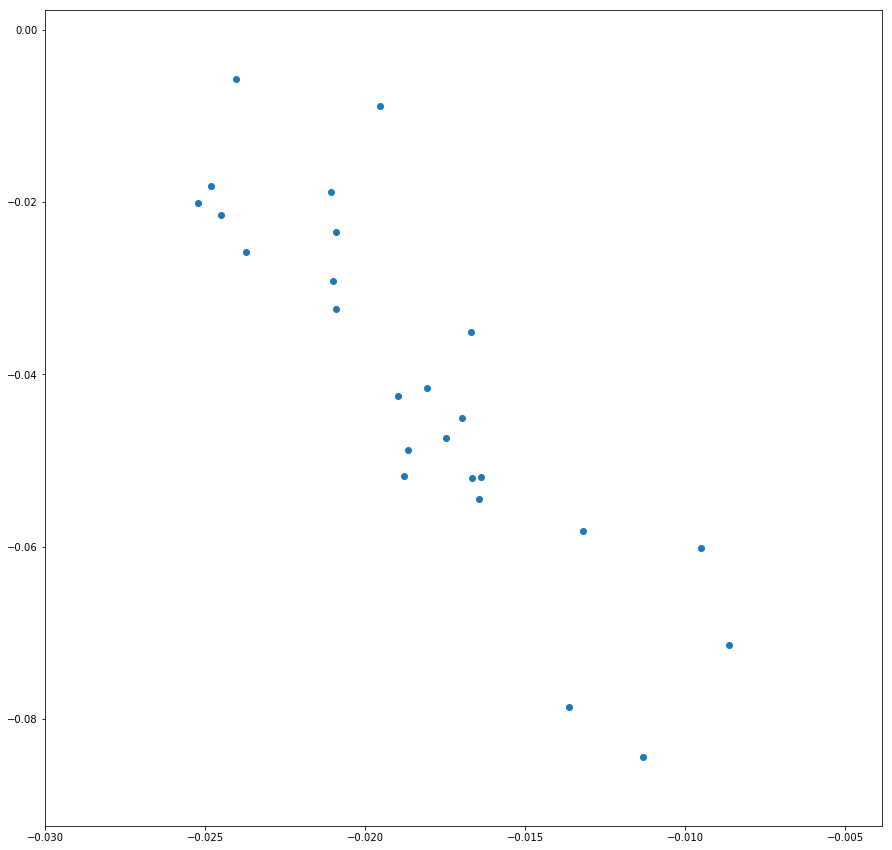

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
for comp in range(15):
    fac1= anime_pca[comp]
    fac2= anime_pca[comp+1]
    #anime_comp = [(f, anime_names[animes[animeid2idx[i]]]) for f,i in zip(fac, topAnime)]
    start=50; end=75
    X = fac1[start:end]
    Y = fac2[start:end]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, x, y in zip(topAnime[start:end], X, Y):
        plt.text(x,y,anime_names[animes[animeid2idx[i]]], color=np.random.rand(3)*0.7, fontsize=14)
    plt.show()
    #plt.plot()
    #print('component'+str(comp)+' top')
    #print('\n')
    #print(sorted(anime_comp, reverse=True)[:10])
    #print('\n')
    #print('component'+str(comp)+' bottom')
    #print('\n')
    #print(sorted(anime_comp)[:10])
    print('\n')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
for comp in range(15):
    fac1= anime_pca[comp]
    fac2= anime_pca[comp+1]
    #anime_comp = [(f, anime_names[animes[animeid2idx[i]]]) for f,i in zip(fac, topAnime)]
    start=25; end=50
    X = fac1[start:end]
    Y = fac2[start:end]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, x, y in zip(topAnime[start:end], X, Y):
        plt.text(x,y,anime_names[animes[animeid2idx[i]]], color=np.random.rand(3)*0.7, fontsize=14)
    plt.show()
    #plt.plot()
    #print('component'+str(comp)+' top')
    #print('\n')
    #print(sorted(anime_comp, reverse=True)[:10])
    #print('\n')
    #print('component'+str(comp)+' bottom')
    #print('\n')
    #print(sorted(anime_comp)[:10])
    print('\n')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
for comp in range(15):
    fac1= anime_pca[comp]
    fac2= anime_pca[comp+1]
    #anime_comp = [(f, anime_names[animes[animeid2idx[i]]]) for f,i in zip(fac, topAnime)]
    
    start=np.random.randint(475) 
    end= start+25
    X = fac1[start:end]
    Y = fac2[start:end]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, x, y in zip(topAnime[start:end], X, Y):
        plt.text(x,y,anime_names[animes[animeid2idx[i]]], color=np.random.rand(3)*0.7, fontsize=14)
    plt.show()
    #plt.plot()
    #print('component'+str(comp)+' top')
    #print('\n')
    #print(sorted(anime_comp, reverse=True)[:10])
    #print('\n')
    #print('component'+str(comp)+' bottom')
    #print('\n')
    #print(sorted(anime_comp)[:10])
    print('\n')

Now we can look the raw weights, rather than the pca:


In [ ]:
anime_weights = anime_emb

In [ ]:
pca2 = PCA(n_components=18)
anime_pca = pca.fit_transform(anime_emb)

In [ ]:
len(anime_pca)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss= StandardScaler()

In [ ]:
scaledweights= ss.fit_transform(anime_weights)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [ ]:
kmc= AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
#kmc = KMeans(n_clusters=18)
# explaining the choices here: cosine means we're looking for cosimiliarity, average linkage helps with our intention of finding generic
# anime genres. 

In [ ]:
kmc.fit(scaledweights)# This step can take a very very long time. 

In [ ]:
klabels= kmc.labels_

In [ ]:
klabels

In [ ]:
animu_cluster =pd.read_csv('animeinfo3.csv')

In [ ]:
animu_cluster['kmeanscluster']='na'

In [ ]:
for animeclusternum in range(len(topAnime)):
    animenum = animes[animeid2idx[topAnime[animeclusternum]]]
    print(klabels[animeclusternum])
    print(anime_names[animes[animeid2idx[topAnime[animeclusternum]]]])
    animu_cluster.loc[(animu_cluster['animeid']==animenum),['kmeanscluster']]=klabels[animeclusternum]

In [ ]:
for clusnum in range(19):
    print('cluster number'+str(clusnum))
    print(animu_cluster[animu_cluster['kmeanscluster']==clusnum]['name'])
    print('\n')

Let's try this another way: using a bias value to seperate out quality.

In [ ]:
def embedding_inputa(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='Anime_Hidden_Factor_Embedding')(inp)
def embedding_inputu(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg),name='User_Hidden_Factor_Embedding')(inp)
def create_biasu(inp, n_in,reg):
    x = Embedding(n_in, 1, input_length=1, W_regularizer=l2(reg),name='Embed_User_Bias')(inp)
    return Flatten()(x)
def create_biasa(inp, n_in,reg):
    x = Embedding(n_in, 1, input_length=1, W_regularizer=l2(reg),name='Embed_Anime_Bias')(inp)
    return Flatten()(x)

In [ ]:
anime_in

In [ ]:

user_in2, u = embedding_inputu('user_id_input', n_users, n_factors, .2)
anime_in2, m = embedding_inputa('anime_id_input', n_animes, n_factors, .2)
ub = create_biasu(user_in2, n_users,.2)
mb = create_biasa(anime_in2, n_animes,.2)

x1 = keras.layers.dot([u, m], axes=2)

In [ ]:
x1 = merge([u, m], mode='dot',name='Dot_Product')
x1 = Flatten()(x1)
x1 = merge([x1, ub], mode='sum',name='Add_User_Bias')
x1 = merge([x1, mb], mode='sum',name='Add_Anime_Bias')
svdb = Model([user_in2, anime_in2], x1,name='Test')
svdb.compile(Adam(0.001), loss='mae')

In [ ]:
svdb.fit([trn.userid, trn.anime_id], trn.score, batch_size=256, nb_epoch=1, 
          validation_data=([val.userid, val.anime_id], val.score))

In [ ]:
plot_model(svdb, to_file='svdb7.png')

In [ ]:
svdb.fit([trn.userid, trn.anime_id], trn.score, batch_size=2560, nb_epoch=8, 
          validation_data=([val.userid, val.anime_id], val.score))

In [ ]:
g=ratings.groupby('animeid')['score'].count()
topAnime=g.sort_values(ascending=False)[:1750]
topAnime = np.array(topAnime.index)

In [ ]:
get_anime_emb2 = Model(anime_in2, m)
anime_emb2 = np.squeeze(get_anime_emb2.predict([topAnime]))
anime_emb.shape


In [ ]:
get_anime_bias2 = Model(anime_in2, mb)
anime_emb = np.squeeze(get_anime_emb.predict([topAnime]))
anime_emb.shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
ss2= StandardScaler()
pca2 = PCA(n_components=12)
anime_pca2 = pca2.fit(anime_emb2.T).components_

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
for comp in range(15):
    fac1= anime_pca2[comp]
    fac2= anime_pca2[comp+1]
    #anime_comp = [(f, anime_names[animes[animeid2idx[i]]]) for f,i in zip(fac, topAnime)]
    start=50; end=75
    X = fac1[start:end]
    Y = fac2[start:end]
    plt.figure(figsize=(15,15))
    plt.scatter(X, Y)
    for i, x, y in zip(topAnime[start:end], X, Y):
        plt.text(x,y,anime_names[animes[animeid2idx[i]]], color=np.random.rand(3)*0.7, fontsize=14)
    plt.show()
    #plt.plot()
    #print('component'+str(comp)+' top')
    #print('\n')
    #print(sorted(anime_comp, reverse=True)[:10])
    #print('\n')
    #print('component'+str(comp)+' bottom')
    #print('\n')
    #print(sorted(anime_comp)[:10])
    print('\n')

In [ ]:
kmc2= AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')
kmc3= AgglomerativeClustering(n_clusters=12, affinity='cosine', linkage='average')

In [ ]:
scaledweights2= ss2.fit_transform(anime_emb2)
scaledweights3= ss2.fit_transform(anime_pca2)

In [ ]:
kmc2.fit(scaledweights2)
kmc3.fit(scaledweights3)

In [ ]:
klabels2= kmc2.labels_

In [ ]:
klabels3= kmc3.labels_

In [ ]:
klabels3

In [ ]:
animu_cluster2 =pd.read_csv('animeinfo3.csv')

In [ ]:
animu_cluster2['kmeanscluster']='na'

In [ ]:
animu_cluster3 =pd.read_csv('animeinfo3.csv')

In [ ]:
animu_cluster3['kmeanscluster']='na'

In [ ]:
for animeclusternum in range(len(topAnime)):
    animenum = animes[animeid2idx[topAnime[animeclusternum]]]
    print(klabels2[animeclusternum])
    print(anime_names[animes[animeid2idx[topAnime[animeclusternum]]]])
    animu_cluster2.loc[(animu_cluster2['animeid']==animenum),['kmeanscluster']]=klabels2[animeclusternum]

In [ ]:
for animeclusternum in range(len(topAnime)):
    animenum = animes[animeid2idx[topAnime[animeclusternum]]]
    print(klabels3[animeclusternum])
    print(anime_names[animes[animeid2idx[topAnime[animeclusternum]]]])
    animu_cluster3.loc[(animu_cluster3['animeid']==animenum),['kmeanscluster']]=klabels3[animeclusternum]